In [1]:
import pandas as pd
import numpy as np


In [9]:
df = pd.read_csv("US-Data-Edited/aggregate-county_all.csv")
df2 = pd.read_csv("US-Data-Edited/covid_usa.csv")

demographic_cols = ['POP13_SQMI', 'WHITE', 'BLACK', 'AMERI_ES', 'ASIAN',
       'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE', 'MALES', 'FEMALES',
       'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19', 'AGE_20_24',
       'AGE_25_34', 'AGE_35_44', 'AGE_45_54', 'AGE_55_64', 'AGE_65_74',
       'AGE_75_84', 'AGE_85_UP','HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M', 'HSEHLD_1_F', 'MARHH_CHD',
       'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD', 'FAMILIES', 'AVE_FAM_SZ',
       'HSE_UNITS', 'VACANT', 'OWNER_OCC', 'RENTER_OCC']
comorbidities_cols = ['Prevalence of obesity','Hypertension', 'Diabetes','CVD','HIV/AIDS']
climate_cols = ['IECC Climate Zone', 'IECC Moisture Regime','BA Climate Zone']
index_cols = ['FIPS', 'STATE_FIPS']
covid_cols = ['population','covid_cases','covid_deaths']

cols_to_normalize = ['WHITE', 'BLACK', 'AMERI_ES', 'ASIAN',
       'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE', 'MALES', 'FEMALES',
       'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19', 'AGE_20_24',
       'AGE_25_34', 'AGE_35_44', 'AGE_45_54', 'AGE_55_64', 'AGE_65_74',
       'AGE_75_84', 'AGE_85_UP','HOUSEHOLDS', 'HSEHLD_1_M', 'HSEHLD_1_F', 'MARHH_CHD',
       'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD', 'FAMILIES',
       'HSE_UNITS', 'VACANT', 'OWNER_OCC', 'RENTER_OCC']+comorbidities_cols+covid_cols[1:]

cols_for_analysis = index_cols + covid_cols + demographic_cols
cols_to_replace_missing = demographic_cols+comorbidities_cols

merged_df = df.merge(df2,on=index_cols)
merged_df.reset_index(inplace=True,drop=True)


for each_col in cols_to_replace_missing: 
    merged_df.loc[merged_df[each_col]<0,each_col] = np.nan
    

# print('khkhh=============================================')


merged_df.loc[:,cols_to_normalize]=merged_df[cols_to_normalize].div(merged_df['population'],axis=0)

merged_df.fillna(merged_df.median(),inplace=True)

# demographic_cols+comorbidities_cols+climate_cols
# np.size(df[index_cols[0]].unique())

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

merged_df[index_cols+demographic_cols+comorbidities_cols+covid_cols]

cols_for_analysis = comorbidities_cols + demographic_cols + covid_cols
spearman_results_case = []
for each_col in cols_for_analysis:
#     print(merged_df[each_col].to_numpy().size)
    sp,pval = spearmanr(merged_df[each_col].to_numpy(),merged_df[covid_cols[1]].to_numpy())
    spearman_results_case.append([each_col,sp,pval])

spearman_results_case_df = pd.DataFrame(spearman_results_case,columns = ["Feature","Spearman_coefficient","P-value"])

spearman_results_case_df.to_csv("US-Data-Edited/spearman_confirmed_tabular.csv",index=False)


#================================================================================
spearman_results_deaths = []
for each_col in cols_for_analysis:
#     print(merged_df[each_col].to_numpy().size)
    sp,pval = spearmanr(merged_df[each_col].to_numpy(),merged_df[covid_cols[2]].to_numpy())
    spearman_results_deaths.append([each_col,sp,pval])

spearman_results_deaths_df = pd.DataFrame(spearman_results_deaths,columns = ["Feature","Spearman_coefficient","P-value"])

spearman_results_deaths_df.to_csv("US-Data-Edited/spearman_deaths_tabular.csv",index=False)




In [66]:
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm

X = merged_df[demographic_cols+comorbidities_cols].to_numpy()
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Y = merged_df[covid_cols[1]].to_numpy()

# lm = linear_model.LinearRegression()
# lm.fit(X_scaled,merged_df[covid_cols[1]].to_numpy())
# lm.coef_
lm_model = sm.OLS(Y,X_scaled)
ols_res = lm_model.fit()
# print("Coefficiecnts: " , ols_res.params)
# print("SE: " , ols_res.bse)
lm_confirmed = zip(demographic_cols+comorbidities_cols,ols_res.params,ols_res.bse,ols_res.pvalues)
lm_confirmed = pd.DataFrame(lm_confirmed,columns=['Feature','Coefficient','SE','P-Values'])
lm_confirmed.to_csv('US-Data-Edited/lm_confirmed.csv',index=False)

# =====================================================================================================
# ====================================     Death vs All                        ========================
# =====================================================================================================

Y = merged_df[covid_cols[2]].to_numpy()

# lm = linear_model.LinearRegression()
# lm.fit(X_scaled,merged_df[covid_cols[1]].to_numpy())
# lm.coef_
lm_model = sm.OLS(Y,X_scaled)
ols_res = lm_model.fit()
# print("Coefficiecnts: " , ols_res.params)
# print("SE: " , ols_res.bse)
lm_confirmed = zip(demographic_cols+comorbidities_cols,ols_res.params,ols_res.bse,ols_res.pvalues)
lm_confirmed = pd.DataFrame(lm_confirmed,columns=['Feature','Coefficient','SE','P-Values'])
lm_confirmed.to_csv('US-Data-Edited/lm_death.csv',index=False)


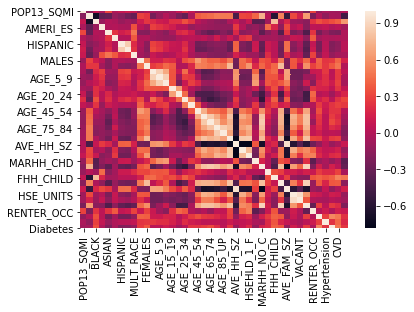

In [59]:
corrmat=merged_df[demographic_cols+comorbidities_cols].corr()

import seaborn as sns
fig = sns.heatmap(corrmat, square=False,)
fig

fig = fig.get_figure()
fig.savefig('US-Data-Edited/corr_heatmap.png',dpi=300,bbox_inches='tight')
corrmat= pd.DataFrame(corrmat)
corrmat.to_csv("US-Data-Edited/Cov_matrix.csv")
# for colname in corrmat.columns:
#     print(colname)
#     print(corrmat[colname][(corrmat[colname]>0.7) & (corrmat[colname]<1)])


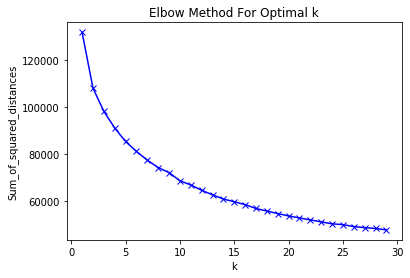

In [70]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [74]:
kmeans_model = KMeans(n_clusters=5,random_state=4).fit(X_scaled)
cluster= kmeans_model.predict(X_scaled)
kmeans_result=merged_df[index_cols + covid_cols + demographic_cols+comorbidities_cols].copy()
kmeans_result['Cluster_No']=cluster
kmeans_result.to_csv('US-Data-Edited/kmeans_result.csv')